## Preamble



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from getdist import plots, MCSamples
plt.rcParams["text.usetex"] = True

## Check minimization algorithm



Parse `qsub` output files



In [1]:
import os, glob

path =r"/home/garrido/Workdir/CMB/analysis/beyondCV/script"
all_files = glob.glob(os.path.join(path, "*.o*"))

chi2_theory = []
chi2_start  = []
success     = []
surveys     = []
start_time  = []
stop_time   = []

def date2time(line):
    import pandas as pd
    time = line.split(" ", maxsplit=3)[-1]
    time = time[:-5].strip()
    return pd.to_datetime(time, format="%c")

for f in all_files:
    find_start = False
    success += [False]
    with open(f) as stream:
        for line in stream:
            if "DEBUG: survey" in line:
                survey = line.split("=")[1].strip()
                if survey == "SO" or survey == "P":
                  survey += "x" + survey
                surveys += [survey]
            if "chi2(theo)/ndf" in line:
                if survey in line:
                    chi2_theory += [float(line.split("=")[1].strip())]
            if "chi2/ndf" in line and not find_start:
                chi2_start += [float(line.split("=")[1].strip())]
                find_start = True
            if "Finished succesfully." in line:
                success[-1] = True
            if "Started on" in line:
                start_time += [date2time(line)]
            if "Ended on" in line:
                stop_time += [date2time(line)]
print("INFO: Read {} files".format(len(all_files)))

Convert `list` into `pandas.DataFrame`



In [1]:
import numpy as np
import pandas as pd
df = pd.DataFrame({"duration": np.array(stop_time)-np.array(start_time),
                   "chi2_theory": chi2_theory,
                   "chi2_start": chi2_start,
                   "success": success})
df.head()

# Out[152]:
#+BEGIN_EXAMPLE
  duration  chi2_theory  chi2_start  success
  0 00:18:22     0.977054    1.327345     True
  1 00:31:34     0.977054    1.472700    False
  2 00:14:12     0.977054    6.900759     True
  3 00:18:42     0.977054    7.013102     True
  4 00:27:40     0.977054    2.224125    False
#+END_EXAMPLE

Get number of sucessful minimization



In [1]:
np.sum(df.success)

Get duration statistics



In [1]:
df.duration.describe()

# Out[150]:
#+BEGIN_EXAMPLE
  count                        97
  mean     0 days 00:20:10.329896
  std      0 days 00:08:08.127261
  min             0 days 00:05:13
  25%             0 days 00:14:12
  50%             0 days 00:18:22
  75%             0 days 00:25:45
  max             0 days 00:45:59
  Name: duration, dtype: object
#+END_EXAMPLE

## Plot cosmological parameters distribution



### Cosmo. parameters LaTeX labels



In [1]:
labels = [r"$\theta_\mathrm{MC}$",
          r"$A_\mathrm{s}$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$",
          r"$\chi^2/\mathrm{ndf}$"]

### Get cosmo. parameters from output file



In [1]:
def get_params(path, pattern="*.likelihood"):
    import os, glob
    all_files = glob.glob(os.path.join(path, pattern))
    # Sort alphabetically
    all_files.sort()

    header = pd.read_csv(all_files[0], delim_whitespace=True).columns[1:]
    df = pd.concat((pd.read_table(f, delim_whitespace=True) for f in all_files))

    # Remove '#' in header
    df.drop(df.columns[[-1,]], axis=1, inplace=True)
    df.columns = header
    df.insert(value=df.chi2/2/1944, column="chi2_ndf", loc=7)
    params = np.array(df.iloc[:, 2:8])
    return params

### Show input values of cosmo. parameters



In [1]:
ref = [1.04164/100, np.exp(3.058)/1e10, 0.9649, 0.02212, 0.1210]
def show_ref(g):
    for i, r in enumerate(ref):
        kwargs = dict(color="gray", ls="--", lw=1)
        for ax in g.subplots[:,i]:
            if ax: ax.axvline(r, **kwargs)
        for ax in g.subplots[i,:i]:
            if ax: ax.axhline(r, **kwargs)

### Results from pure Planck simulation



#### Cosmo. parameters distribution



In [1]:
params = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/unbinned")
samples = MCSamples(samples=params, names=labels)

# Out[6]:

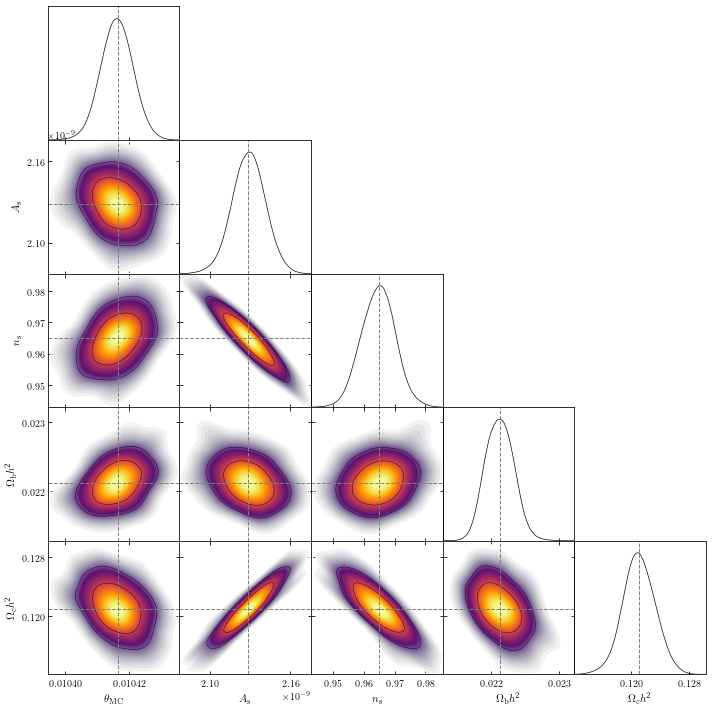

In [1]:
g = plots.getSubplotPlotter()
g.settings.colormap = "inferno"
g.triangle_plot(samples, params=labels[:-1], shaded=True)
show_ref(g)

# Out[7]:

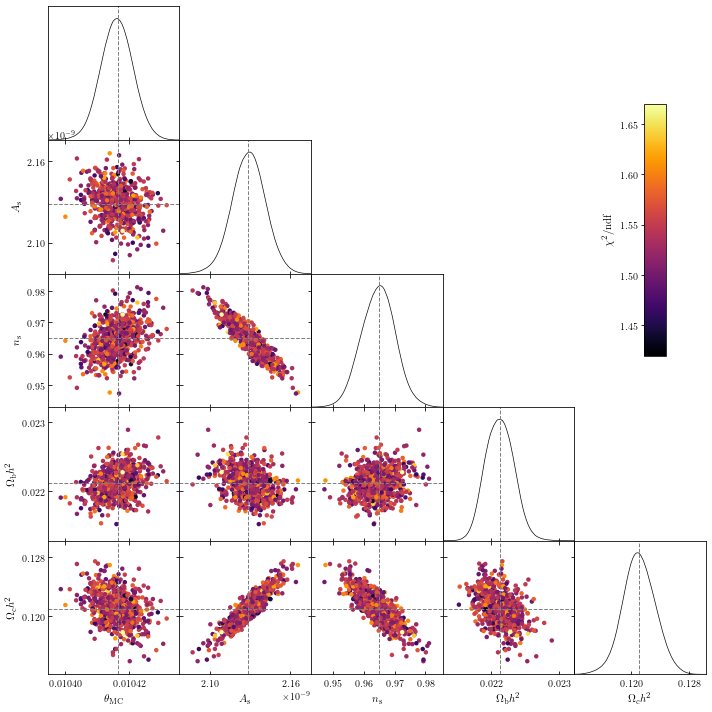

In [1]:
g = plots.getSubplotPlotter()
g.settings.colormap_scatter = "inferno"
g.triangle_plot(samples, params=labels[:-1],
                plot_3d_with_param="$\chi^2/\mathrm{ndf}$", scatter_size=20)
show_ref(g)

In [1]:
print("Number of sucessful minimization :", np.alen(params))

Number of sucessful minimization : 638

In [1]:
min_mean = np.mean(params, axis=0)
min_std  = np.std(params, axis=0)
fisher = np.array([5.1265507267143515e-06, 1.2854648947626772e-11, 0.005589724100405197, 0.00020382255228959767, 0.002334040314343261, 1.])
lines = [[r"$\mu$"], [r"$\sigma$"], [r"$\sigma$ (Fisher)"], [r"$\Delta\sigma$ (min-Fisher) [%]"]]
table = np.stack([min_mean, min_std, fisher, 100*(min_std-fisher)/fisher])
table = np.append(lines, table, axis=1)

In [1]:
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

# Out[17]:
<IPython.core.display.HTML object>

In [1]:
print(tabulate.tabulate(table, headers=labels, tablefmt="orgtbl"))

|                                 | $\theta_\mathrm{MC}$ | $A_\mathrm{s}$ | $n_\mathrm{s}$ | $\Omega_\mathrm{b}h^2$ | $\Omega_\mathrm{c}h^2$ | $\chi^2/\mathrm{ndf}$ |
|---------------------------------+----------------------+----------------+----------------+------------------------+------------------------+-----------------------|
| $\mu$                           |            0.0104162 |    2.12887e-09 |       0.964695 |              0.0221223 |                0.12108 |               1.53808 |
| $\sigma$                        |          4.99937e-06 |    1.24047e-11 |     0.00544548 |            0.000206822 |              0.0022281 |               0.03946 |
| $\sigma$ (Fisher)               |          5.12655e-06 |    1.28546e-11 |     0.00558972 |            0.000203823 |             0.00233404 |                     1 |
| $\Delta\sigma$ (min-Fisher) [%] |             -2.48081 |        -3.5002 |       -2.58047 |                1.47141 |                -4.5391 |               -96.054 

### Results from 100 simulations



Simulations are all the same (seed is 31415) and we estimate the intrinsic variance on
cosmo. parameters *i.e.* the systematics from minimization.



In [1]:
params = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/100_sims_syst")
samples = MCSamples(samples=params, names=labels)

# Out[38]:

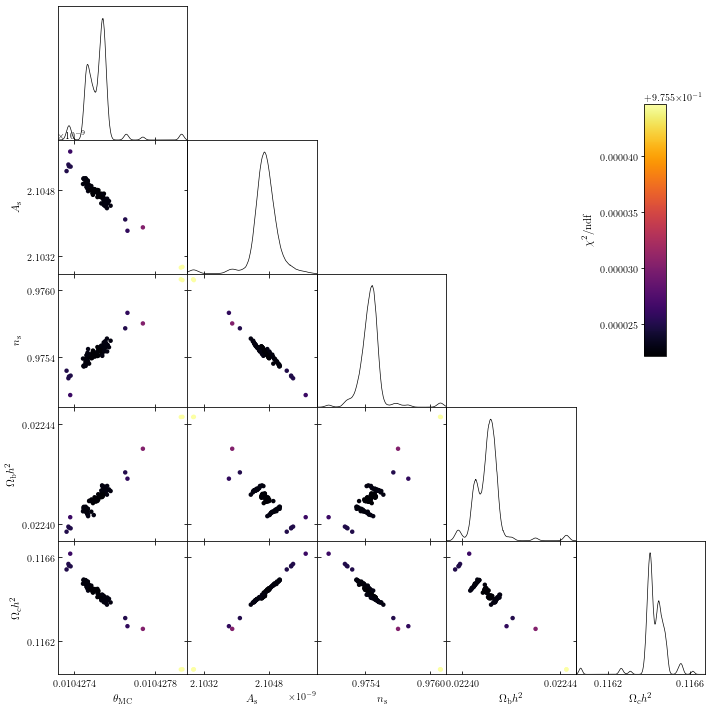

In [1]:
g = plots.getSubplotPlotter()
g.settings.colormap_scatter = "inferno"
g.triangle_plot(samples, params=labels[:-1],
                plot_3d_with_param="$\chi^2/\mathrm{ndf}$", scatter_size=20)
show_ref(g)

In [1]:
min_mean = np.mean(params, axis=0)
min_std  = np.std(params, axis=0)
lines = [[r"$\mu$"], [r"$\sigma$"]]
table = np.stack([min_mean, min_std])
table = np.append(lines, table, axis=1)

In [1]:
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

# Out[17]:
<IPython.core.display.HTML object>

In [1]:
print(tabulate.tabulate(table, headers=labels, tablefmt="orgtbl"))

|          | $\theta_\mathrm{MC}$ | $A_\mathrm{s}$ | $n_\mathrm{s}$ | $\Omega_\mathrm{b}h^2$ | $\Omega_\mathrm{c}h^2$ | $\chi^2/\mathrm{ndf}$ |
|----------+----------------------+----------------+----------------+------------------------+------------------------+-----------------------|
| $\mu$    |            0.0104275 |    2.10469e-09 |       0.975453 |              0.0224105 |               0.116425 |              0.975523 |
| $\sigma$ |          8.08209e-08 |    3.69492e-13 |    0.000129202 |            6.52134e-06 |            7.14235e-05 |           3.21921e-06 |

## Simons Observatory ⊗ Planck



In [1]:
params_SO   = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_2000", "*SO.likelihood")
params_SOxP = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_2000", "*SOxP.likelihood")
params_P    = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_2000", "*_P.likelihood")
params_SO.shape, params_SOxP.shape, params_P.shape

# Out[47]:
((971, 6), (971, 6), (971, 6))

In [1]:
samples_SO   = MCSamples(samples=params_SO, names=labels, label="SOxSO")
samples_SOxP = MCSamples(samples=params_SOxP, names=labels, label="SOxP")
samples_P    = MCSamples(samples=params_P, names=labels, label="PxP")

# Out[49]:

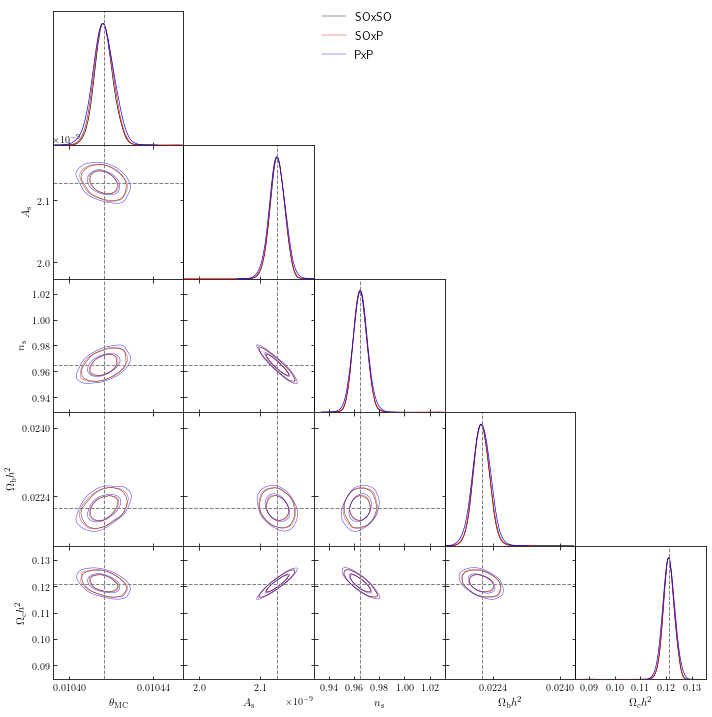

In [1]:
g = plots.getSubplotPlotter()
# g.settings.colormap = "inferno"
g.triangle_plot([samples_SO, samples_SOxP, samples_P], params=labels[:-1])
show_ref(g)

In [1]:
lines = [[r"$\mu$(SOxSO)"], [r"$\mu$(SOxP)"], [r"$\mu$(PxP)"],
         [r"$\sigma$(SOxSO)"], [r"$\sigma$(SOxP)"], [r"$\sigma$(PxP)"],
         [r"$\sigma$(SOxSO - PxP)"], [r"$\sigma$(SOxSO - SOxP)"], [r"$\sigma$(SOxSO + PxP - 2 SOxP"]]
table = np.stack([np.mean(params_SO, axis=0),
                  np.mean(params_SOxP, axis=0),
                  np.mean(params_P, axis=0),
                  np.std(params_SO, axis=0),
                  np.std(params_SOxP, axis=0),
                  np.std(params_P, axis=0),
                  np.std(params_SO-params_P, axis=0),
                  np.std(params_SO-params_SOxP, axis=0),
                  np.std(params_SO + params_P - 2*params_SOxP, axis=0)
])
table = np.append(lines, table, axis=1)
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

In [1]:
print(tabulate.tabulate(table, headers=labels, tablefmt="orgtbl"))

|                               | $\theta_\mathrm{MC}$ | $A_\mathrm{s}$ | $n_\mathrm{s}$ | $\Omega_\mathrm{b}h^2$ | $\Omega_\mathrm{c}h^2$ | $\chi^2/\mathrm{ndf}$ |
|-------------------------------+----------------------+----------------+----------------+------------------------+------------------------+-----------------------|
| $\mu$(SOxSO)                  |            0.0104165 |    2.12888e-09 |       0.964796 |               0.022119 |               0.121061 |               1.00019 |
| $\mu$(SOxP)                   |            0.0104165 |    2.12863e-09 |       0.964918 |              0.0221197 |               0.121011 |               1.00034 |
| $\mu$(PxP)                    |            0.0104164 |    2.12876e-09 |       0.964918 |               0.022122 |               0.121043 |               1.00003 |
| $\sigma$(SOxSO)               |          4.35923e-06 |    1.19063e-11 |     0.00529269 |            0.000197395 |             0.00208537 |             0.0319118 |
| $\sigma$

| |$\theta_\mathrm{MC}$|$A_\mathrm{s}$|$n_\mathrm{s}$|$\Omega_\mathrm{b}h^2$|$\Omega_\mathrm{c}h^2$|$\chi^2/\mathrm{ndf}$|
|---|---|---|---|---|---|---|
| $\mu$(SOxSO)|0.0104163|2.1288e-09|0.964831|0.0221165|0.121037|0.998797|
| $\mu$(SOxP)|0.0104162|2.12874e-09|0.964837|0.0221241|0.121029|1.00012|
| $\mu$(PxP)|0.0104161|2.12891e-09|0.964766|0.0221283|0.121065|0.999338|
| $\sigma$(SOxSO)|3.30158e-06|8.82142e-12|0.00403527|0.000113061|0.00147556|0.0259158|
| $\sigma$(SOxP)|4.13856e-06|1.10042e-11|0.0048009|0.000153239|0.00196259|0.0260542|
| $\sigma$(PxP)|4.88563e-06|1.22407e-11|0.00529792|0.000204028|0.0022389|0.0249852|
| $\sigma$(SOxSO - PxP)|3.76192e-06|9.58206e-12|0.00406034|0.000171957|0.00181588|0.024773|
| $\sigma$(SOxSO - SOxP)|2.53148e-06|7.13821e-12|0.00291831|0.000104709|0.00135525|0.0210134|



# Out[52]:

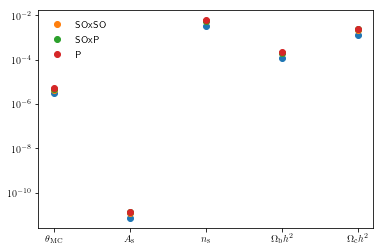

In [1]:
plt.semilogy()
x = np.arange(5)
plt.plot(x, np.std(params_SO-params_P, axis=0)[:-1], "o")
plt.plot(x, np.std(params_SO, axis=0)[:-1], "o", label="SOxSO")
plt.plot(x, np.std(params_SOxP, axis=0)[:-1], "o", label="SOxP")
plt.plot(x, np.std(params_P, axis=0)[:-1], "o", label="P")
plt.xticks(x, labels[:-1])
plt.legend()